# 4 - Results Analysis and Visualizations



In [1]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, HTML
import os
from sklearn.metrics import root_mean_squared_error
from matplotlib.lines import Line2D

# Imputation evaluation


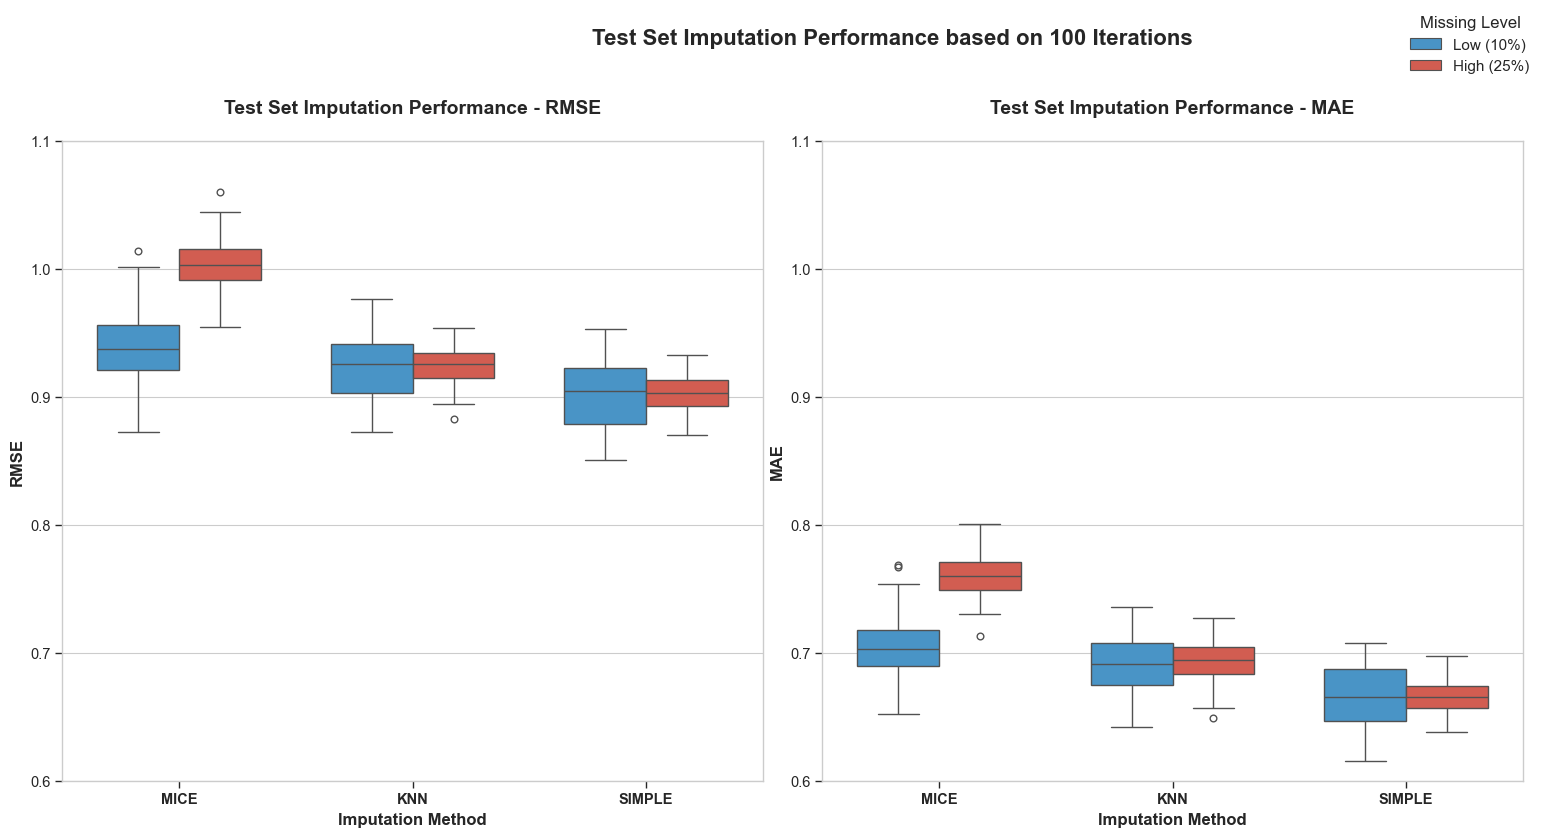

In [2]:
# boxplot on imputation results
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)

imputation_data = pd.read_csv("results/imputation_summary.csv")
test_data = imputation_data[imputation_data['data_set'] == 'test']

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)
colors = {"low": "#3498db", "high": "#e74c3c"}

sns.boxplot(
    data=test_data, 
    x="method", 
    y="rmse", 
    hue="missing_level",
    palette=colors,
    ax=axes[0],
    dodge=True,
    width=0.7
)

sns.boxplot(
    data=test_data, 
    x="method", 
    y="mae", 
    hue="missing_level",
    palette=colors,
    ax=axes[1],
    dodge=True,
    width=0.7
)

for i, metric in enumerate(["RMSE", "MAE"]):
    axes[i].set_title(f"Test Set Imputation Performance - {metric}", fontsize=14, fontweight='bold', pad=20)
    axes[i].set_xlabel("Imputation Method", fontsize=12, fontweight='bold')
    axes[i].set_ylabel(metric, fontsize=12, fontweight='bold')
    axes[i].set_ylim(0.6, 1.1)

    tick_positions = range(len(axes[i].get_xticklabels()))
    axes[i].set_xticks(tick_positions)
    axes[i].set_xticklabels([label.get_text().upper() for label in axes[i].get_xticklabels()], 
                           fontweight='bold')
    
    if axes[i].get_legend():
        axes[i].get_legend().remove()
        
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles[:2], ["Low (10%)", "High (25%)"], 
          title="Missing Level", 
          title_fontsize=12,
          fontsize=11,
          loc="center left", 
          bbox_to_anchor=(0.78, 1.0))

plt.suptitle("Test Set Imputation Performance based on 100 Iterations", 
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [3]:

# summary table on imputation results
avg_metrics = imputation_data.groupby(['data_set', 'method', 'missing_level'])[['rmse', 'mae']].mean().reset_index()

def create_performance_table():
    results = []
    
    for dataset in ['train', 'test']:
        for method in sorted(avg_metrics['method'].unique()):
            low_data = avg_metrics[(avg_metrics['data_set'] == dataset) & 
                                   (avg_metrics['method'] == method) & 
                                   (avg_metrics['missing_level'] == 'low')]
            
            high_data = avg_metrics[(avg_metrics['data_set'] == dataset) & 
                                    (avg_metrics['method'] == method) & 
                                    (avg_metrics['missing_level'] == 'high')]
            
            if low_data.empty or high_data.empty:
                continue
                
            low_rmse = low_data['rmse'].values[0]
            high_rmse = high_data['rmse'].values[0]
            low_mae = low_data['mae'].values[0]
            high_mae = high_data['mae'].values[0]
            
            rmse_pct_change = ((high_rmse / low_rmse) - 1) * 100
            mae_pct_change = ((high_mae / low_mae) - 1) * 100
            
            results.append({
                'Dataset': dataset.capitalize(),
                'Method': method.upper(),
                'RMSE (Low 10%)': low_rmse,
                'RMSE (High 25%)': high_rmse,
                'RMSE % Change': rmse_pct_change,
                'MAE (Low 10%)': low_mae,
                'MAE (High 25%)': high_mae,
                'MAE % Change': mae_pct_change
            })
    
    table = pd.DataFrame(results)
    
    for col in table.columns:
        if col not in ['Dataset', 'Method']:
            if 'Change' in col:
                table[col] = table[col].round(2)  
            else:
                table[col] = table[col].round(4)  
    
    return table

performance_table = create_performance_table()
display(HTML(performance_table.to_html(index=False)))


Dataset,Method,RMSE (Low 10%),RMSE (High 25%),RMSE % Change,MAE (Low 10%),MAE (High 25%),MAE % Change
Train,KNN,0.9135,0.9186,0.56,0.6840,0.6876,0.54
Train,MICE,0.9187,0.9555,4.01,0.6867,0.7163,4.31
Train,SIMPLE,0.9046,0.9046,0.01,0.6685,0.6685,-0.01
Test,KNN,0.9227,0.9241,0.15,0.6904,0.6938,0.50
Test,MICE,0.9399,1.0047,6.89,0.7042,0.7594,7.83
Test,SIMPLE,0.9025,0.9018,-0.08,0.6657,0.6662,0.08


# Feature-wise imputation evaluation

In [4]:

# define features with missing values by type and mechanism
missing_features = {
    'MCAR': {
        'continuous': ['cont_0', 'cont_1', 'cont_2'],
        'discrete': ['disc_2', 'disc_4'],
        'categorical': ['cat_0_Yes', 'cat_3_Yes']
    },
    'MAR': {
        'continuous': ['cont_3', 'cont_4', 'cont_5'],
        'discrete': ['disc_0', 'disc_1'],
        'categorical': ['cat_4_Level_B', 'cat_4_Level_C']
    }
}

all_missing_features = []
feature_type_map = {}
feature_mechanism_map = {}

for mechanism, types in missing_features.items():
    for feature_type, features in types.items():
        all_missing_features.extend(features)
        for feature in features:
            feature_type_map[feature] = feature_type
            feature_mechanism_map[feature] = mechanism

def evaluate_imputation_by_feature_type(iteration=1, dataset_type='test', missing_level='low'):
    
    base_path = "/Users/eva.berezovska/Desktop/Dissertation/Simulation_final/data"
    complete_path = f"{base_path}/complete/iteration_{iteration}"
    amputed_path = f"{base_path}/amputed/iteration_{iteration}"
    imputed_path = f"{base_path}/imputed/iteration_{iteration}"
    
    complete_df = pd.read_csv(f"{complete_path}/{dataset_type}_complete.csv")
    amputed_df = pd.read_csv(f"{amputed_path}/{dataset_type}_{missing_level}.csv")
    
    mice_df = pd.read_csv(f"{imputed_path}/{dataset_type}_{missing_level}_mice.csv")
    knn_df = pd.read_csv(f"{imputed_path}/{dataset_type}_{missing_level}_knn.csv")
    simple_df = pd.read_csv(f"{imputed_path}/{dataset_type}_{missing_level}_simple.csv")
    
    results = []
    
    for feature in all_missing_features:
        missing_mask = amputed_df[feature].isna()
        n_missing = missing_mask.sum()
        
        if n_missing == 0:
            continue
        
        true_values = complete_df.loc[missing_mask, feature].values
        
        mice_values = mice_df.loc[missing_mask, feature].values
        knn_values = knn_df.loc[missing_mask, feature].values
        simple_values = simple_df.loc[missing_mask, feature].values
        
        mice_rmse = root_mean_squared_error(true_values, mice_values)
        knn_rmse = root_mean_squared_error(true_values, knn_values)
        simple_rmse = root_mean_squared_error(true_values, simple_values)
        
        feature_type = feature_type_map[feature]
        mechanism = feature_mechanism_map[feature]
        
        results.append({
            'iteration': iteration,
            'dataset': dataset_type,
            'missing_level': missing_level,
            'feature': feature,
            'feature_type': feature_type,
            'mechanism': mechanism,
            'n_missing': n_missing,
            'mice_rmse': mice_rmse,
            'knn_rmse': knn_rmse,
            'simple_rmse': simple_rmse
        })
    
    return pd.DataFrame(results)

def process_all_iterations(iterations=range(1, 101), dataset_types=['test'], missing_levels=['low', 'high']):
    all_results = []
    
    for iteration in iterations: 
        for dataset_type in dataset_types:
            for missing_level in missing_levels:
                    results = evaluate_imputation_by_feature_type(
                        iteration=iteration,
                        dataset_type=dataset_type,
                        missing_level=missing_level
                    )
                    all_results.append(results)
    
    combined_results = pd.concat(all_results, ignore_index=True)
    
    # save results
    os.makedirs("results", exist_ok=True)
    combined_results.to_csv("results/feature_type_imputation_performance.csv", index=False)
    
    return combined_results

feature_results = process_all_iterations()

melted_results = pd.melt(
    feature_results,
    id_vars=['iteration', 'dataset', 'missing_level', 'feature', 'feature_type', 'mechanism'],
    value_vars=['mice_rmse', 'knn_rmse', 'simple_rmse'],
    var_name='method',
    value_name='rmse'
)
melted_results['method'] = melted_results['method'].str.replace('_rmse', '')

# MAR vs MCAR

<Figure size 1600x800 with 0 Axes>

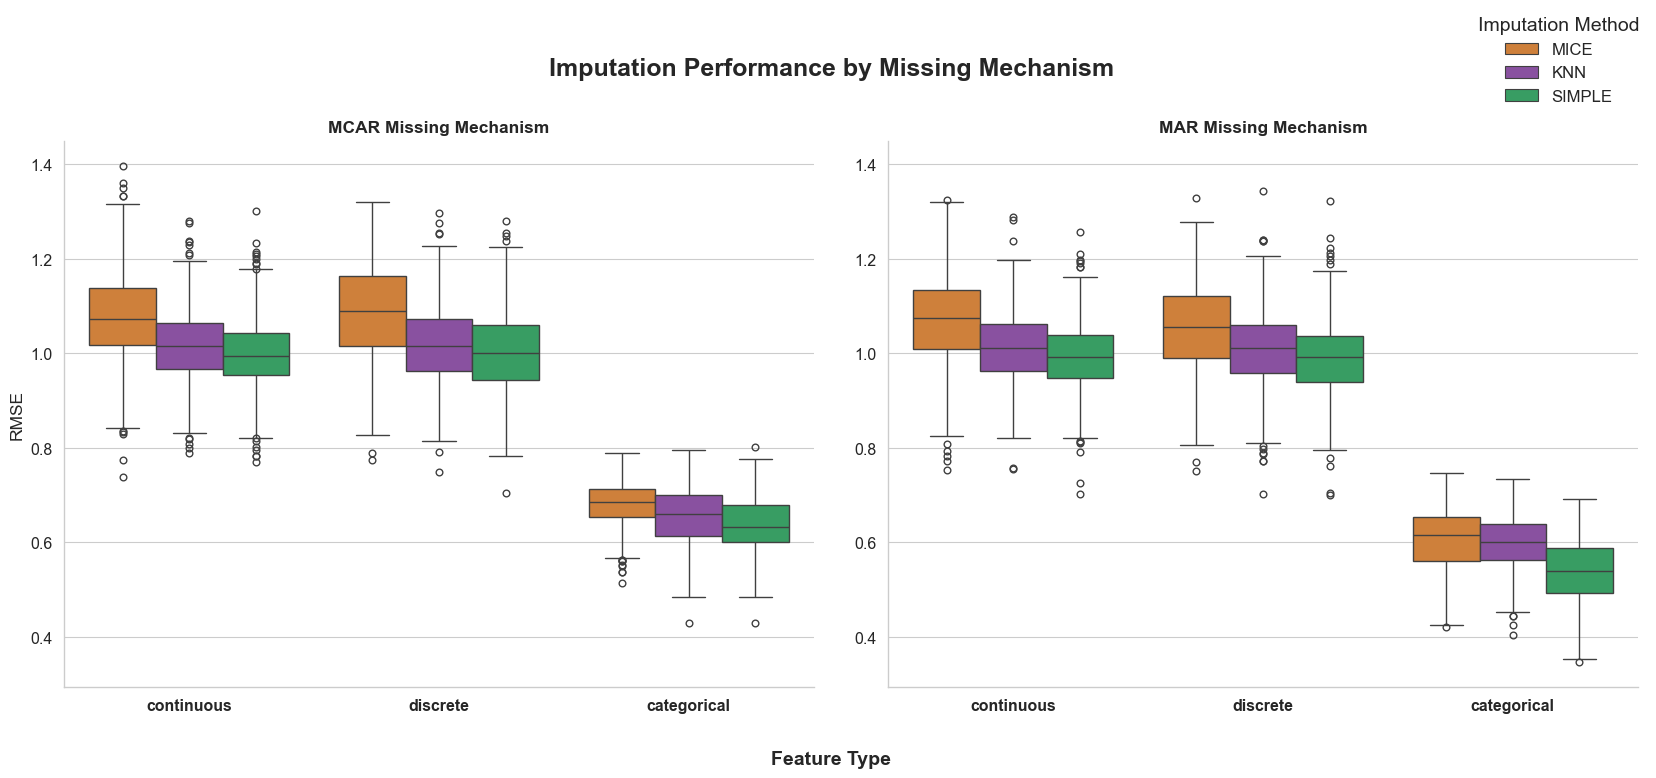

In [6]:
# missing mechanism (MCAR vs MAR)
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)

method_colors = {
    "mice": "#e67e22",    
    "knn": "#8e44ad",     
    "simple": "#27ae60"   
}

g = sns.FacetGrid(
    melted_results,
    col='mechanism',
    height=7, aspect=1.2,
    sharey=True
)

g.map_dataframe(
    sns.boxplot,
    x='feature_type',
    y='rmse',
    hue='method',
    palette=method_colors,
    order=['continuous', 'discrete', 'categorical']
)

g.set_axis_labels("", "RMSE")
g.set_titles("{col_name} Missing Mechanism", fontweight='bold')

for ax in g.axes.flat:
    if ax.get_legend():
        ax.get_legend().remove()
        
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')
        tick.set_text(tick.get_text().capitalize())  
    
    ax.tick_params(axis='y', which='major', labelleft=True)

fig = plt.gcf()
fig.text(0.5, 0.01, "Feature Type", ha='center', fontsize=14, fontweight='bold')

g.fig.suptitle('Imputation Performance by Missing Mechanism', fontsize=18, fontweight='bold', y=1.02)


handles, labels = ax.get_legend_handles_labels()
method_labels = [label.upper() for label in labels]  
fig.legend(handles, method_labels, 
          title="Imputation Method", 
          title_fontsize=14,
          fontsize=12,
          loc="upper right", 
          bbox_to_anchor=(0.99, 1.1))

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.12, right=0.98, wspace=0.1)  
plt.show()

# Low vs High missing rate

<Figure size 1600x800 with 0 Axes>

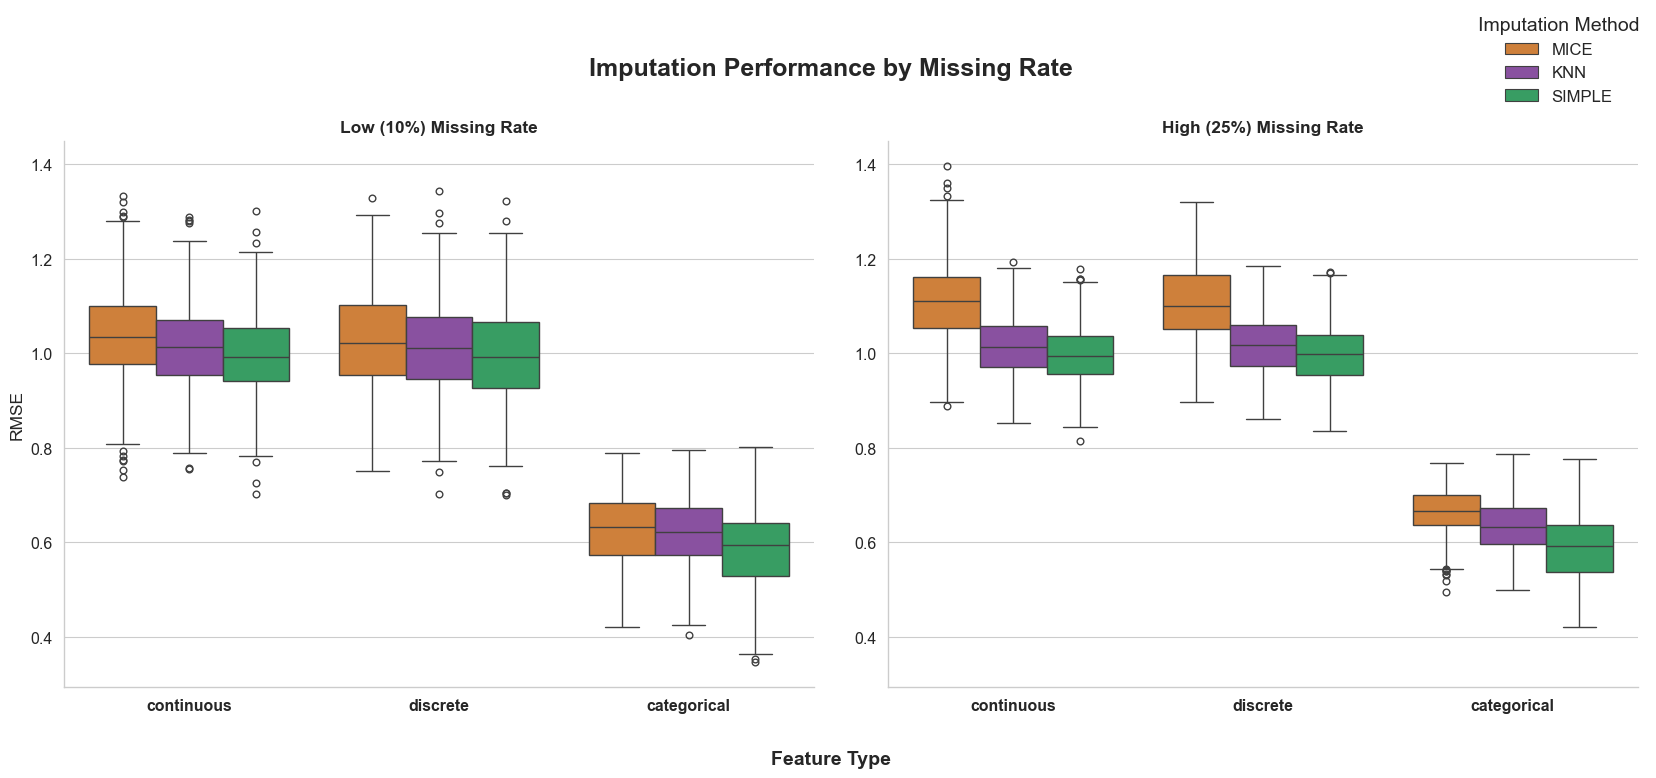

In [7]:
# low vs high 
plt.figure(figsize=(16, 8))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3)

method_colors = {
    "mice": "#e67e22",    
    "knn": "#8e44ad",     
    "simple": "#27ae60"   
}

g = sns.FacetGrid(
    melted_results,
    col='missing_level',
    height=7, aspect=1.2,
    sharey=True
)

g.map_dataframe(
    sns.boxplot,
    x='feature_type',
    y='rmse',
    hue='method',
    palette=method_colors,
    order=['continuous', 'discrete', 'categorical']
)

g.set_axis_labels("", "RMSE")

for i, level in enumerate(['low', 'high']):
    title = "Low (10%)" if level == "low" else "High (25%)"
    g.axes[0, i].set_title(f"{title} Missing Rate", fontweight='bold')

for ax in g.axes.flat:
    if ax.get_legend():
        ax.get_legend().remove()
        
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')
        tick.set_text(tick.get_text().capitalize())  
    
    ax.tick_params(axis='y', which='major', labelleft=True)

fig = plt.gcf()
fig.text(0.5, 0.01, "Feature Type", ha='center', fontsize=14, fontweight='bold')

g.fig.suptitle('Imputation Performance by Missing Rate', fontsize=18, fontweight='bold', y=1.02)

handles, labels = ax.get_legend_handles_labels()
method_labels = [label.upper() for label in labels]  
fig.legend(handles, method_labels, 
          title="Imputation Method", 
          title_fontsize=14,
          fontsize=12,
          loc="upper right", 
          bbox_to_anchor=(0.99, 1.1))

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.12, right=0.98, wspace=0.1)
plt.show()

# Tables for by feature comparison 

In [8]:

mechanism_table = melted_results.groupby(['mechanism', 'feature_type', 'method'])['rmse'].mean().reset_index()

mechanism_pivot = mechanism_table.pivot_table(
    values='rmse',
    index='feature_type',
    columns=['method', 'mechanism'],
    aggfunc='mean'
).round(2)

mechanism_pivot.columns = [f"{method.upper()} ({mechanism})" for method, mechanism in mechanism_pivot.columns]

ordered_columns = []
for method in ['mice', 'knn', 'simple']:
    ordered_columns.extend([f"{method.upper()} (MCAR)", f"{method.upper()} (MAR)"])
mechanism_pivot = mechanism_pivot[ordered_columns]

mechanism_pivot = mechanism_pivot.reindex(['continuous', 'discrete', 'categorical'])

print("Table: RMSE by Missing Mechanism and Feature Type")
display(HTML(mechanism_pivot.to_html()))

Table: RMSE by Missing Mechanism and Feature Type


,MICE (MCAR),MICE (MAR),KNN (MCAR),KNN (MAR),SIMPLE (MCAR),SIMPLE (MAR)
feature_type,,,,,,
continuous,1.08,1.07,1.02,1.01,1.00,0.99
discrete,1.08,1.05,1.02,1.01,1.00,0.99
categorical,0.68,0.61,0.66,0.60,0.64,0.54


In [9]:

level_table = melted_results.groupby(['missing_level', 'feature_type', 'method'])['rmse'].mean().reset_index()

level_pivot = level_table.pivot_table(
    values='rmse',
    index='feature_type',
    columns=['method', 'missing_level'],
    aggfunc='mean'
).round(2)

level_pivot.columns = [f"{method.upper()} ({level.capitalize()})" for method, level in level_pivot.columns]

ordered_columns = []
for method in ['mice', 'knn', 'simple']:
    ordered_columns.extend([f"{method.upper()} (Low)", f"{method.upper()} (High)"])
level_pivot = level_pivot[ordered_columns]

level_pivot = level_pivot.reindex(['continuous', 'discrete', 'categorical'])

print("\nTable: RMSE by Missing Rate and Feature Type")
display(HTML(level_pivot.to_html()))


Table: RMSE by Missing Rate and Feature Type


,MICE (Low),MICE (High),KNN (Low),KNN (High),SIMPLE (Low),SIMPLE (High)
feature_type,,,,,,
continuous,1.04,1.11,1.01,1.01,1.00,1.00
discrete,1.03,1.11,1.01,1.02,1.00,1.00
categorical,0.62,0.66,0.62,0.63,0.59,0.59


# Classification

In [10]:

# load classification summary data
classification_data = pd.read_csv("results/classification_summary.csv") 

In [11]:

# test scores only
test_data = classification_data[['classifier', 'imputation', 'missing_level', 'test_accuracy', 'test_f1']]

avg_performance = test_data.groupby(['classifier', 'imputation', 'missing_level'])[
    ['test_accuracy', 'test_f1']
].mean().reset_index()

def create_classification_table():
    results = []
    
    clf_labels = {'svm': 'SVM', 'random_forest': 'Random Forest', 'neural_network': 'Neural Network'}
    imp_labels = {'complete': 'Complete Data', 'mice': 'MICE', 'knn': 'KNN', 'simple': 'Simple'}
    
    for classifier in ['svm', 'random_forest', 'neural_network']:
        for imputation in ['complete', 'mice', 'knn', 'simple']:
            low_data = avg_performance[
                (avg_performance['classifier'] == classifier) & 
                (avg_performance['imputation'] == imputation) & 
                (avg_performance['missing_level'] == 'low')
            ]
            
            high_data = avg_performance[
                (avg_performance['classifier'] == classifier) & 
                (avg_performance['imputation'] == imputation) & 
                (avg_performance['missing_level'] == 'high')
            ]
            
            if imputation == 'complete':
                complete_data = avg_performance[
                    (avg_performance['classifier'] == classifier) & 
                    (avg_performance['imputation'] == imputation)
                ]
                
                if not complete_data.empty:
                    low_acc = high_acc = complete_data['test_accuracy'].values[0]
                    low_f1 = high_f1 = complete_data['test_f1'].values[0]
                else:
                    continue
            else:
                if low_data.empty or high_data.empty:
                    continue
                    
                low_acc = low_data['test_accuracy'].values[0]
                high_acc = high_data['test_accuracy'].values[0]
                low_f1 = low_data['test_f1'].values[0]
                high_f1 = high_data['test_f1'].values[0]
            
            results.append({
                'Classifier': clf_labels[classifier],
                'Imputation': imp_labels[imputation],
                'Accuracy (Low 10%)': low_acc,
                'Accuracy (High 25%)': high_acc,
                'F1 Score (Low 10%)': low_f1,
                'F1 Score (High 25%)': high_f1
            })
    
    table = pd.DataFrame(results)
    
    for col in table.columns:
        if col not in ['Classifier', 'Imputation']:
            table[col] = table[col].round(4)  
    
    classifier_order = ['SVM', 'Random Forest', 'Neural Network']
    imputation_order = ['Complete Data', 'MICE', 'KNN', 'Simple']
    
    table['Classifier'] = pd.Categorical(table['Classifier'], categories=classifier_order)
    table['Imputation'] = pd.Categorical(table['Imputation'], categories=imputation_order)
    
    table = table.sort_values(['Classifier', 'Imputation'])
    
    return table

classification_table = create_classification_table()
display(HTML(classification_table.to_html(index=False)))


Classifier,Imputation,Accuracy (Low 10%),Accuracy (High 25%),F1 Score (Low 10%),F1 Score (High 25%)
SVM,Complete Data,0.9269,0.9269,0.9469,0.9469
SVM,MICE,0.9337,0.8833,0.9519,0.9139
SVM,KNN,0.8875,0.8262,0.9184,0.8744
SVM,Simple,0.8875,0.8351,0.9182,0.8815
Random Forest,Complete Data,0.7623,0.7623,0.8507,0.8507
Random Forest,MICE,0.7945,0.8265,0.8682,0.8705
Random Forest,KNN,0.7590,0.6697,0.8445,0.7432
Random Forest,Simple,0.7606,0.7586,0.8485,0.8180
Neural Network,Complete Data,0.9236,0.9236,0.9443,0.9443
Neural Network,MICE,0.9323,0.8883,0.9508,0.9174


In [12]:

# for both train and test metrics
train_test_data = classification_data[['classifier', 'imputation', 'missing_level', 
                                      'train_accuracy', 'train_f1',
                                      'test_accuracy', 'test_f1']]

avg_performance = train_test_data.groupby(['classifier', 'imputation', 'missing_level'])[
    ['train_accuracy', 'train_f1', 'test_accuracy', 'test_f1']
].mean().reset_index()

def create_classification_table():
    results = []
    
    clf_labels = {'svm': 'SVM', 'random_forest': 'Random Forest', 'neural_network': 'Neural Network'}
    imp_labels = {'complete': 'Complete Data', 'mice': 'MICE', 'knn': 'KNN', 'simple': 'Simple'}
    
    for classifier in ['svm', 'random_forest', 'neural_network']:
        for imputation in ['complete', 'mice', 'knn', 'simple']:
            low_data = avg_performance[
                (avg_performance['classifier'] == classifier) & 
                (avg_performance['imputation'] == imputation) & 
                (avg_performance['missing_level'] == 'low')
            ]
            
            high_data = avg_performance[
                (avg_performance['classifier'] == classifier) & 
                (avg_performance['imputation'] == imputation) & 
                (avg_performance['missing_level'] == 'high')
            ]
            
            if imputation == 'complete':
                complete_data = avg_performance[
                    (avg_performance['classifier'] == classifier) & 
                    (avg_performance['imputation'] == imputation)
                ]
                
                if not complete_data.empty:
                    low_train_acc = high_train_acc = complete_data['train_accuracy'].values[0]
                    low_train_f1 = high_train_f1 = complete_data['train_f1'].values[0]
                    low_test_acc = high_test_acc = complete_data['test_accuracy'].values[0]
                    low_test_f1 = high_test_f1 = complete_data['test_f1'].values[0]
                else:
                    continue
            else:
                if low_data.empty or high_data.empty:
                    continue
                    
                low_train_acc = low_data['train_accuracy'].values[0]
                high_train_acc = high_data['train_accuracy'].values[0]
                low_train_f1 = low_data['train_f1'].values[0]
                high_train_f1 = high_data['train_f1'].values[0]

                low_test_acc = low_data['test_accuracy'].values[0]
                high_test_acc = high_data['test_accuracy'].values[0]
                low_test_f1 = low_data['test_f1'].values[0]
                high_test_f1 = high_data['test_f1'].values[0]
            
            results.append({
                'Classifier': clf_labels[classifier],
                'Imputation': imp_labels[imputation],
                'Train Accuracy (Low 10%)': low_train_acc,
                'Train Accuracy (High 25%)': high_train_acc,
                'Train F1 (Low 10%)': low_train_f1,
                'Train F1 (High 25%)': high_train_f1,
                'Test Accuracy (Low 10%)': low_test_acc,
                'Test Accuracy (High 25%)': high_test_acc,
                'Test F1 (Low 10%)': low_test_f1,
                'Test F1 (High 25%)': high_test_f1
            })
    

    table = pd.DataFrame(results)
    
    for col in table.columns:
        if col not in ['Classifier', 'Imputation']:
            table[col] = table[col].round(4)  
    
    classifier_order = ['SVM', 'Random Forest', 'Neural Network']
    imputation_order = ['Complete Data', 'MICE', 'KNN', 'Simple']
    
    table['Classifier'] = pd.Categorical(table['Classifier'], categories=classifier_order)
    table['Imputation'] = pd.Categorical(table['Imputation'], categories=imputation_order)
    
    table = table.sort_values(['Classifier', 'Imputation'])
    
    return table

classification_table = create_classification_table()

display(HTML(classification_table.to_html(index=False)))

Classifier,Imputation,Train Accuracy (Low 10%),Train Accuracy (High 25%),Train F1 (Low 10%),Train F1 (High 25%),Test Accuracy (Low 10%),Test Accuracy (High 25%),Test F1 (Low 10%),Test F1 (High 25%)
SVM,Complete Data,0.9506,0.9506,0.9636,0.9636,0.9269,0.9269,0.9469,0.9469
SVM,MICE,0.9616,0.9797,0.9718,0.9853,0.9337,0.8833,0.9519,0.9139
SVM,KNN,0.9332,0.8946,0.9511,0.9241,0.8875,0.8262,0.9184,0.8744
SVM,Simple,0.9099,0.8613,0.9342,0.8999,0.8875,0.8351,0.9182,0.8815
Random Forest,Complete Data,0.8032,0.8032,0.8761,0.8761,0.7623,0.7623,0.8507,0.8507
Random Forest,MICE,0.8506,0.9243,0.9036,0.9432,0.7945,0.8265,0.8682,0.8705
Random Forest,KNN,0.8480,0.8979,0.9015,0.9241,0.7590,0.6697,0.8445,0.7432
Random Forest,Simple,0.8038,0.8284,0.8757,0.8698,0.7606,0.7586,0.8485,0.8180
Neural Network,Complete Data,0.9934,0.9934,0.9947,0.9947,0.9236,0.9236,0.9443,0.9443
Neural Network,MICE,0.9963,0.9869,0.9970,0.9905,0.9323,0.8883,0.9508,0.9174


# Density plots

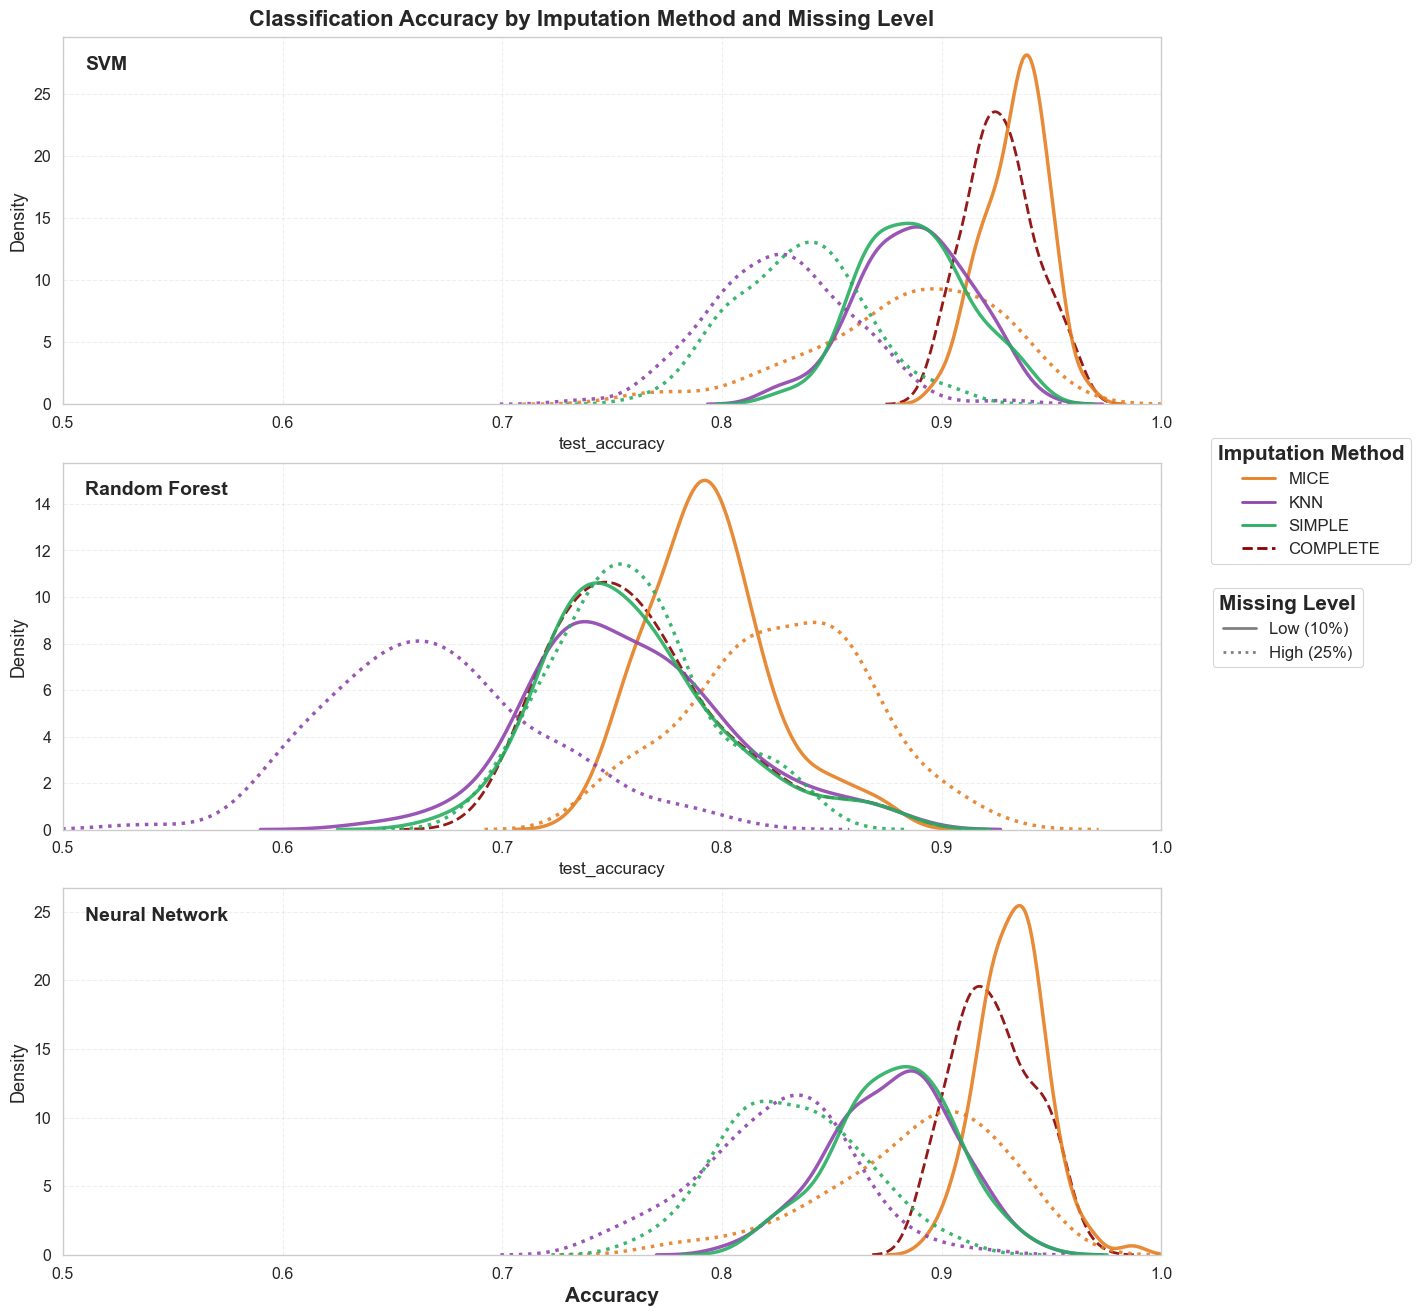

In [13]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.3)

method_colors = {
    "mice": "#e67e22",    
    "knn": "#8e44ad",     
    "simple": "#27ae60",  
    "complete": "#8B0000" 
}

fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=False)

for i, classifier in enumerate(['svm', 'random_forest', 'neural_network']):
    if classifier == "random_forest":
        display_name = "Random Forest"
    elif classifier == "neural_network":
        display_name = "Neural Network"
    else:
        display_name = "SVM"
    
    metric = 'test_accuracy'
    ax = axes[i]
    
    complete_data = classification_data[
        (classification_data['classifier'] == classifier) & 
        (classification_data['imputation'] == 'complete')
    ]
    
    if len(complete_data) > 5:
        sns.kdeplot(
            data=complete_data,
            x=metric,
            ax=ax,
            color=method_colors["complete"],
            linestyle='--',  
            linewidth=2.0,
            alpha=0.9,
            label=f"COMPLETE"
        )
    elif not complete_data.empty:
        complete_mean = complete_data[metric].mean()
        ax.axvline(
            x=complete_mean, 
            color=method_colors["complete"],
            linestyle='--', 
            alpha=0.9, 
            linewidth=1.5,
            label='COMPLETE'
        )
    
    for method in ['mice', 'knn', 'simple']:
        for level, style in [('low', '-'), ('high', ':')]:
            data_subset = classification_data[
                (classification_data['classifier'] == classifier) & 
                (classification_data['imputation'] == method) &
                (classification_data['missing_level'] == level)
            ]
            
            sns.kdeplot(
                data=data_subset,
                x=metric,
                ax=ax,
                color=method_colors[method],
                linestyle=style,
                linewidth=2.5,
                alpha=0.9,
                label=f"{method.upper()} ({level})"
            )
    
    ax.text(0.02, 0.95, display_name, 
           transform=ax.transAxes, 
           fontsize=14, 
           fontweight='bold',
           va='top')
    ax.set_ylabel('Density', fontsize=13)
    

    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim(0.5, 1.0)
    

    ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_xticklabels(['0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
    
    if i == 2:
        ax.set_xlabel('Accuracy', fontsize=15, fontweight='bold')
    
    if i < 2:  
        ax.get_legend().remove() if ax.get_legend() else None


method_elements = []
for method in ['mice', 'knn', 'simple', 'complete']:
    style = '--' if method == 'complete' else '-'
    method_elements.append(
        Line2D([0], [0], color=method_colors[method], lw=2, linestyle=style, label=method.upper())
    )

level_elements = [
    Line2D([0], [0], color='gray', lw=2, linestyle='-', label='Low (10%)'),
    Line2D([0], [0], color='gray', lw=2, linestyle=':', label='High (25%)')
]

legend1 = fig.legend(
    handles=method_elements,
    loc='upper right', 
    bbox_to_anchor=(1.19, 0.7),
    ncol=1, 
    fontsize=12,
    frameon=True,
    title="Imputation Method",
    title_fontsize=15
)
legend1.get_title().set_fontweight('bold')

legend2 = fig.legend(
    handles=level_elements,
    loc='upper right', 
    bbox_to_anchor=(1.15, 0.6),
    ncol=1,  
    fontsize=12,
    frameon=True,
    title="Missing Level",
    title_fontsize=15,
)
legend2.get_title().set_fontweight('bold')

fig.suptitle('Classification Accuracy by Imputation Method and Missing Level', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  

plt.show()

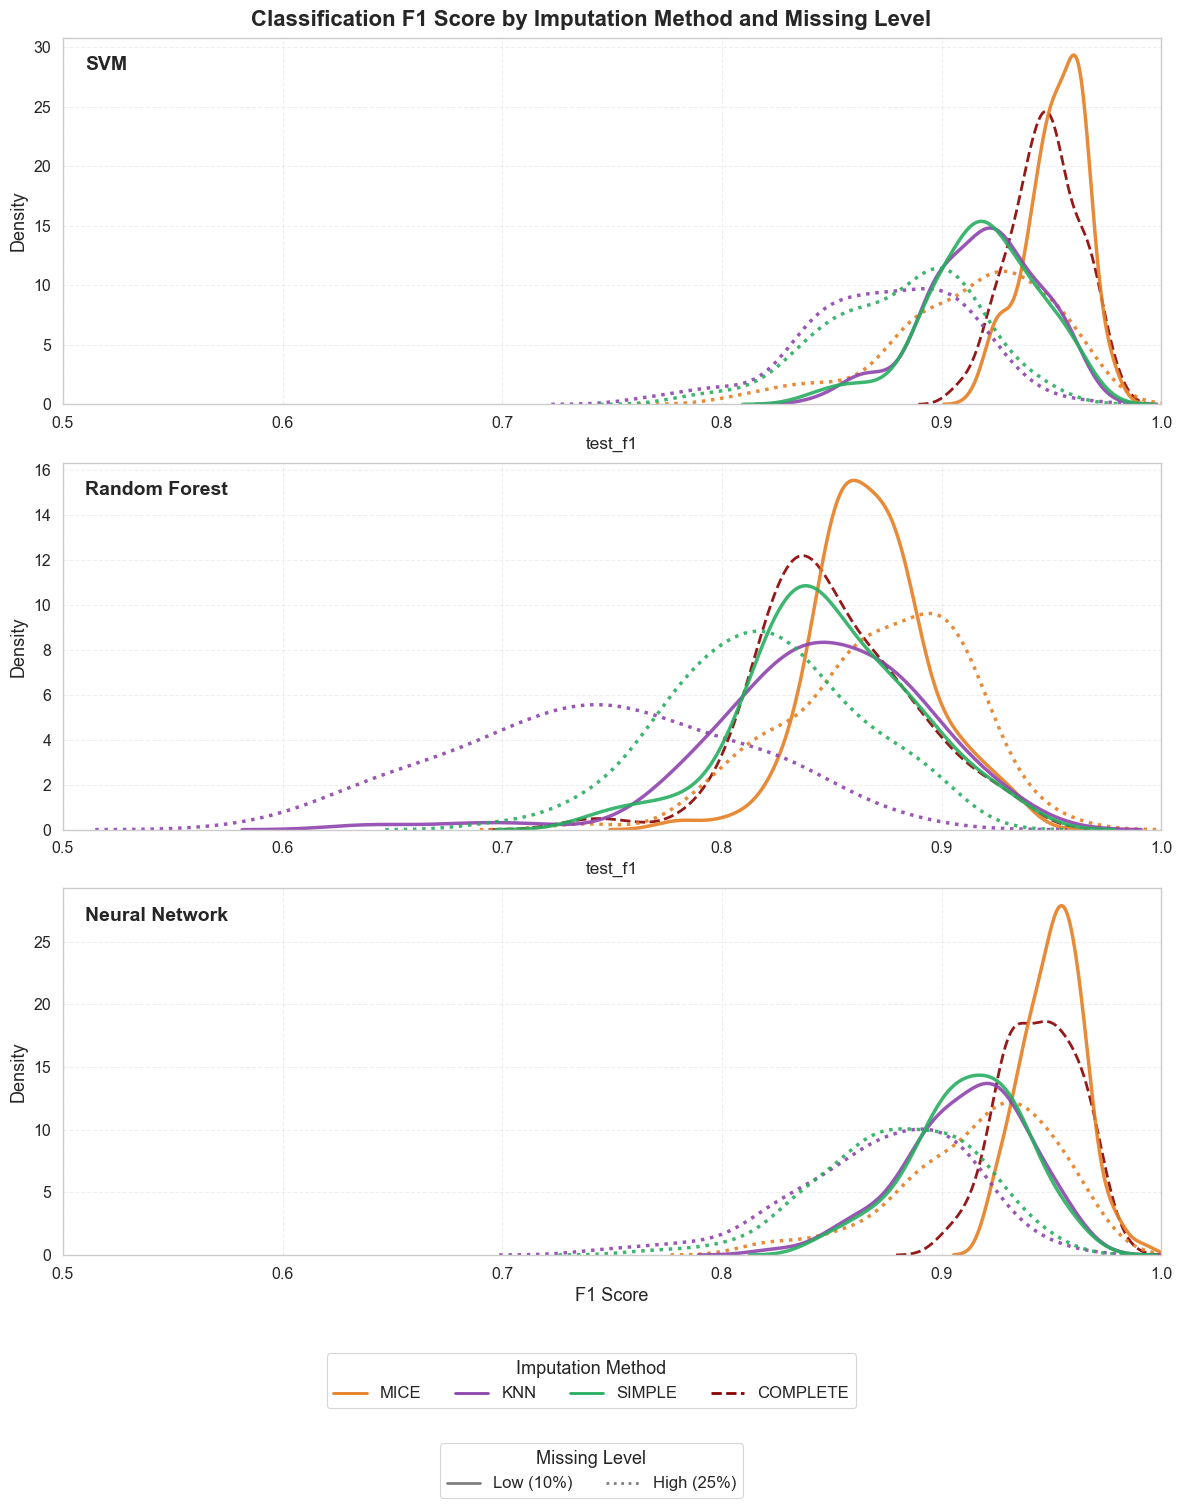

In [14]:
# density plots F1 Score
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.3)

method_colors = {
    "mice": "#e67e22",    
    "knn": "#8e44ad",     
    "simple": "#27ae60",  
    "complete": "#8B0000" 
}

fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=False)

for i, classifier in enumerate(['svm', 'random_forest', 'neural_network']):
    if classifier == "random_forest":
        display_name = "Random Forest"
    elif classifier == "neural_network":
        display_name = "Neural Network"
    else:
        display_name = "SVM"
    
    metric = 'test_f1'
    ax = axes[i]
    
    complete_data = classification_data[
        (classification_data['classifier'] == classifier) & 
        (classification_data['imputation'] == 'complete')
    ]
    
    if len(complete_data) > 5:
        sns.kdeplot(
            data=complete_data,
            x=metric,
            ax=ax,
            color=method_colors["complete"],
            linestyle='--',  
            linewidth=2.0,
            alpha=0.9,
            label=f"COMPLETE"
        )
    elif not complete_data.empty:
        complete_mean = complete_data[metric].mean()
        ax.axvline(
            x=complete_mean, 
            color=method_colors["complete"],
            linestyle='--', 
            alpha=0.9, 
            linewidth=1.5,
            label='Complete'
        )
    
    for method in ['mice', 'knn', 'simple']:
        for level, style in [('low', '-'), ('high', ':')]:
            data_subset = classification_data[
                (classification_data['classifier'] == classifier) & 
                (classification_data['imputation'] == method) &
                (classification_data['missing_level'] == level)
            ]
            
            sns.kdeplot(
                data=data_subset,
                x=metric,
                ax=ax,
                color=method_colors[method],
                linestyle=style,
                linewidth=2.5,
                alpha=0.9,
                label=f"{method.upper()} ({level})"
            )
    
    ax.text(0.02, 0.95, display_name, 
           transform=ax.transAxes, 
           fontsize=14, 
           fontweight='bold',
           va='top')
    ax.set_ylabel('Density', fontsize=13)
    
    ax.grid(True, alpha=0.3, linestyle='--')
    
    ax.set_xlim(0.5, 1.0)
    
    ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_xticklabels(['0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
    
    if i == 2:
        ax.set_xlabel('F1 Score', fontsize=13)
    
    if i < 2:  
        ax.get_legend().remove() if ax.get_legend() else None

from matplotlib.lines import Line2D

method_elements = []
for method in ['mice', 'knn', 'simple', 'complete']:
    style = '--' if method == 'complete' else '-'
    method_elements.append(
        Line2D([0], [0], color=method_colors[method], lw=2, linestyle=style, label=method.upper())
    )

level_elements = [
    Line2D([0], [0], color='gray', lw=2, linestyle='-', label='Low (10%)'),
    Line2D([0], [0], color='gray', lw=2, linestyle=':', label='High (25%)')
]

fig.legend(
    handles=method_elements,
    loc='upper center', 
    bbox_to_anchor=(0.5, 0.09),
    ncol=4,
    fontsize=12,
    frameon=True,
    title="Imputation Method",
    title_fontsize=13
)

fig.legend(
    handles=level_elements,
    loc='upper center', 
    bbox_to_anchor=(0.5, 0.03),
    ncol=2,
    fontsize=12,
    frameon=True,
    title="Missing Level",
    title_fontsize=13
)

fig.suptitle('Classification F1 Score by Imputation Method and Missing Level', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  

plt.show()

# Feature importance


In [15]:

# load feature importance data
feature_importance = pd.read_csv("results/feature_importance.csv")

high_importance = ['cont_0', 'cont_3', 'cont_7', 'disc_1', 'disc_3', 'cat_0_Yes', 'cat_2_Yes']  # 7 features
medium_importance = ['cont_1', 'cont_5', 'cont_9', 'cont_11', 'cont_13', 'disc_0', 'disc_4', 'cat_1_Yes', 'cat_4_Level_C']  # 9 features
all_features = feature_importance['feature'].unique()
low_importance = [col for col in all_features if col not in high_importance + medium_importance]  # remaining features

match_results = []

# group by iteration, classifier, imputation method, and missing level
groups = feature_importance.groupby(['iteration', 'classifier', 'imputation', 'missing_level'])

for name, group in groups:
    iter_num, clf, imp, level = name
    
    if len(group) < len(high_importance) + len(medium_importance) + len(low_importance):
        continue
        
    sorted_features = group.sort_values('importance', ascending=False)['feature'].tolist()
    
    # get predicted sets (top 7, next 9, rest)
    predicted_high = set(sorted_features[:len(high_importance)])
    predicted_medium = set(sorted_features[len(high_importance):len(high_importance)+len(medium_importance)])
    predicted_low = set(sorted_features[len(high_importance)+len(medium_importance):])
    
    # calculate set-based matches (number of features correctly categorized)
    high_match = len(predicted_high.intersection(high_importance))
    medium_match = len(predicted_medium.intersection(medium_importance))
    low_match = len(predicted_low.intersection(low_importance))
    
    # calculate match percentages
    high_pct = 100 * high_match / len(high_importance)
    medium_pct = 100 * medium_match / len(medium_importance)
    low_pct = 100 * low_match / len(low_importance)
    
    # calculate overall match percentage weighted by category size
    total_features = len(high_importance) + len(medium_importance) + len(low_importance)
    overall_pct = 100 * (high_match + medium_match + low_match) / total_features
    
    match_results.append({
        'iteration': iter_num,
        'classifier': clf,
        'imputation': imp,
        'missing_level': level,
        'high_match_count': high_match,
        'medium_match_count': medium_match,
        'low_match_count': low_match,
        'high_match_pct': high_pct,
        'medium_match_pct': medium_pct,
        'low_match_pct': low_pct,
        'overall_match_pct': overall_pct
    })

match_summary = pd.DataFrame(match_results)

# save to CSV
match_summary.to_csv("results/feature_importance_match_summary.csv", index=False)

clf_labels = {'svm': 'SVM', 'random_forest': 'Random Forest', 'neural_network': 'Neural Network'}
imp_labels = {'complete': 'Complete Data', 'mice': 'MICE', 'knn': 'KNN', 'simple': 'Simple'}

In [16]:

# calculate average match accuracy across all iterations 
avg_accuracy = match_summary.groupby(['classifier', 'imputation', 'missing_level'])[
    ['high_match_pct', 'medium_match_pct', 'low_match_pct', 'overall_match_pct']
].mean().reset_index()

clf_labels = {'svm': 'SVM', 'random_forest': 'Random Forest', 'neural_network': 'Neural Network'}
imp_labels = {'complete': 'Complete Data', 'mice': 'MICE', 'knn': 'KNN', 'simple': 'Simple'}

avg_accuracy['Classifier'] = avg_accuracy['classifier'].map(clf_labels)
avg_accuracy['Imputation'] = avg_accuracy['imputation'].map(imp_labels)

classifier_order = ['SVM', 'Random Forest', 'Neural Network']
imputation_order = ['Complete Data', 'MICE', 'KNN', 'Simple']

low_data = avg_accuracy[avg_accuracy['missing_level'] == 'low'].copy()

low_pivot = pd.pivot_table(
    low_data,
    values=['high_match_pct', 'medium_match_pct', 'low_match_pct', 'overall_match_pct'],
    index=['Classifier', 'Imputation'],
    aggfunc='mean'
).round(2)

low_pivot.columns = ['High Importance (%)', 'Medium Importance (%)', 'Low Importance (%)', 'Average (%)']

low_pivot = low_pivot.reset_index()

low_pivot['Classifier'] = pd.Categorical(low_pivot['Classifier'], categories=classifier_order)
low_pivot['Imputation'] = pd.Categorical(low_pivot['Imputation'], categories=imputation_order)
low_pivot = low_pivot.sort_values(['Classifier', 'Imputation'])

low_pivot['Rank'] = low_pivot['Average (%)'].rank(ascending=False).astype(int)

styled_low = low_pivot.style\
    .format({
        'High Importance (%)': '{:.2f}%',
        'Medium Importance (%)': '{:.2f}%',
        'Low Importance (%)': '{:.2f}%',
        'Average (%)': '{:.2f}%'
    })\
    .set_caption("Feature Importance Match Accuracy - Low (10%) Missing Level")

high_data = avg_accuracy[avg_accuracy['missing_level'] == 'high'].copy()

high_pivot = pd.pivot_table(
    high_data,
    values=['high_match_pct', 'medium_match_pct', 'low_match_pct', 'overall_match_pct'],
    index=['Classifier', 'Imputation'],
    aggfunc='mean'
).round(2)

high_pivot.columns = ['High Importance (%)', 'Medium Importance (%)', 'Low Importance (%)', 'Average (%)']

high_pivot = high_pivot.reset_index()

high_pivot['Classifier'] = pd.Categorical(high_pivot['Classifier'], categories=classifier_order)
high_pivot['Imputation'] = pd.Categorical(high_pivot['Imputation'], categories=imputation_order)
high_pivot = high_pivot.sort_values(['Classifier', 'Imputation'])

high_pivot['Rank'] = high_pivot['Average (%)'].rank(ascending=False).astype(int)

styled_high = high_pivot.style\
    .format({
        'High Importance (%)': '{:.2f}%',
        'Medium Importance (%)': '{:.2f}%',
        'Low Importance (%)': '{:.2f}%',
        'Average (%)': '{:.2f}%'
    })\
    .set_caption("Feature Importance Match Accuracy - High (25%) Missing Level")


display(HTML(low_pivot.to_html(index=False)))


display(HTML(high_pivot.to_html(index=False)))


Classifier,Imputation,High Importance (%),Medium Importance (%),Low Importance (%),Average (%),Rank
SVM,MICE,85.29,86.7,74.00,81.92,1
SVM,KNN,83.29,87.2,73.22,81.31,2
SVM,Simple,82.57,86.5,71.67,80.31,3
Random Forest,MICE,63.57,65.3,46.78,58.42,7
Random Forest,KNN,63.14,65.3,46.89,58.35,8
Random Forest,Simple,63.57,58.8,42.78,54.54,9
Neural Network,MICE,70.14,77.6,56.44,68.27,4
Neural Network,KNN,68.86,75.8,54.11,66.42,5
Neural Network,Simple,68.57,74.3,53.11,65.42,6


Classifier,Imputation,High Importance (%),Medium Importance (%),Low Importance (%),Average (%),Rank
SVM,MICE,63.57,70.6,49.67,61.46,3
SVM,KNN,72.43,80.1,62.11,71.81,2
SVM,Simple,77.14,81.3,64.67,74.42,1
Random Forest,MICE,61.00,65.8,45.67,57.54,6
Random Forest,KNN,54.43,64.2,43.67,54.46,8
Random Forest,Simple,56.71,55.9,36.00,49.23,9
Neural Network,MICE,66.00,65.6,46.56,59.12,5
Neural Network,KNN,64.57,65.9,47.56,59.19,4
Neural Network,Simple,62.57,64.9,45.11,57.42,7
